In [1]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

import pandas as pd
import numpy as np
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder

# Autoreload
%load_ext autoreload
%autoreload 2

In [2]:
data_original = pd.read_csv('../raw_data/inViales_completa.csv')

# Drop duplicates
data_original = data_original[data_original.drop(columns='folio').duplicated() == False]

# FOR NOW DROP THE 'D' CLASS IN codigo_cierre
data_original = data_original[(data_original['codigo_cierre'] == 'D') == False]

# Drop unimportant columns
data_original = data_original.drop(columns=['folio', 'fecha_cierre', 'hora_cierre', 'clas_con_f_alarma', 'alcaldia_cierre', 'colonia'])

In [3]:
data = pd.read_csv('../raw_data/inViales_completa.csv')

# Drop duplicates
data = data[data.drop(columns='folio').duplicated() == False]


# FOR NOW DROP THE 'D' CLASS IN codigo_cierre
data = data[(data['codigo_cierre'] == 'D') == False]


# Drop unimportant columns
data = data.drop(columns=['folio', 'fecha_cierre', 'hora_cierre', 'clas_con_f_alarma', 'colonia'])

# fin_semana 
fin_semana = (data['dia_semana'] == 'Sabado') | (data['dia_semana'] == 'Domingo')
data['fin_semana'] = fin_semana
data['fin_semana'] = data['fin_semana'].replace({True: 1, False : 0})


# alcaldia_inicio imputer
imputer = SimpleImputer(missing_values=np.nan, strategy='most_frequent') 
imputer.fit(data[['alcaldia_inicio']])
data[['alcaldia_inicio']] = imputer.transform(data[['alcaldia_inicio']])

# alcaldia_cierre imputer
imputer = SimpleImputer(missing_values=np.nan, strategy='most_frequent') 
imputer.fit(data[['alcaldia_cierre']])
data[['alcaldia_cierre']] = imputer.transform(data[['alcaldia_cierre']])

# # colonia imputer
# imputer = SimpleImputer(strategy="most_frequent") 
# imputer.fit(data[['colonia']])
# data[['colonia']] = imputer.transform(data[['colonia']])


# hora_creacion imputer
imputer = SimpleImputer(strategy='most_frequent')
imputer.fit(data[['hora_creacion']])
data[['hora_creacion']] = imputer.transform(data[['hora_creacion']])


# Cyclical Engineering hora_creacion
data['hora_creacion'] = pd.to_timedelta(data['hora_creacion'])
data['hora_creacion'] = data['hora_creacion'].dt.total_seconds() / (60 * 60)

data['sin_enc_hora_creacion'] = np.sin(2*np.pi*data.hora_creacion/24) # 24 hr a day
data['cos_enc_hora_creacion'] = np.cos(2*np.pi*data.hora_creacion/24)


# hora_pico
def hora_pico(row):
    hour_calc = row['hora_creacion']
    if hour_calc >= 7.5 and hour_calc <= 9.5:  # Verificar la hora entre 07:30 y 09:30
        return 1
    elif row['fecha_creacion'][:4] >= '2021' and (hour_calc >= 14 and hour_calc <= 15):  # A partir de marzo de 2020, verificar la hora entre 14:00 y 15:00
        return 1
    elif hour_calc >= 18 and hour_calc <= 19:  # Verificar la hora entre 18:00 y 19:00
        return 1
    else:
        return 0

data['hora_pico'] = data.apply(hora_pico, axis=1)


# ids_clasificacion completely correlated with alcaldia_inicio
# classification_dict = {
#     "AZCAPOTZALCO": 0.8786,
#     "COYOACAN": 0.8761,
#     "CUAJIMALPA DE MORELOS": 0.8422,
#     "GUSTAVO A. MADERO": 0.8401,
#     "IZTACALCO": 0.8494,
#     "IZTAPALAPA": 0.8030,
#     "LA MAGDALENA CONTRERAS": 0.8269,
#     "MILPA ALTA": 0.7582,
#     "ALVARO OBREGON": 0.8455,
#     "TLAHUAC": 0.8088,
#     "TLALPAN": 0.8309,
#     "XOCHIMILCO": 0.8026,
#     "BENITO JUAREZ": 0.9321,
#     "CUAUHTEMOC": 0.8483,
#     "MIGUEL HIDALGO": 0.8943,
#     "VENUSTIANO CARRANZA": 0.8355
# }
# data['ids_clasificacion'] = data['alcaldia_inicio'].map(classification_dict)


# dias_festivos
dias_festivos = ['01-01', '02-05', '03-21', '05-01', '08-16', '12-25']
def festividades(d):
    if d[5:] in dias_festivos:
        return 1
    return 0

data['dia_festivo'] = data['fecha_creacion'].apply(festividades)


# incidente_c4 class reduction
incidente_c4_dict = {
    'Incidente de tránsito': 'Choque sin lesionados',
    'Accidente automovilístico': 'Choque sin lesionados',
    'Choque con prensados': 'Choque con lesionados',
    'Persona atropellada': 'Atropellado',
    'Volcadura': 'Volcadura',
    'Monopatín': 'Ciclista',
    'Vehiculo atrapado': 'Vehículo atrapadovarado',
    'Vehiculo desbarrancado': 'Vehículo atrapadovarado',
    'Ferroviario': 'Vehículo atrapadovarado'
}
data['incidente_c4'] = data['incidente_c4'].replace(incidente_c4_dict)


# tipo_incidentes_c4 class reduction
tipo_incidente_c4_dict = {
    'Detención ciudadana': 'Accidente',
    'Sismo': 'Accidente',
    'Mi Calle': 'Accidente',
    'Mi Taxi': 'Accidente'
}
data['tipo_incidente_c4'] = data['tipo_incidente_c4'].replace(tipo_incidente_c4_dict)


# tipo_entrada class reduction
tipo_entrada_dict = {
    'LLAMADA APP911': 'LLAMADA DEL 911',
    'LLAMADA DEL 066': 'LLAMADA DEL 911',
    'BOTÓN DE AUXILIO': 'BOTÓN DE AUXILIO',
    'ZELLO': 'RADIO',
    'LECTOR DE PLACAS': 'CÁMARA',
    'APLICATIVOS': 'RADIO',
}
data['tipo_entrada'] = data['tipo_entrada'].replace(tipo_entrada_dict)


# tipo_entrada imputer
data['tipo_entrada'].fillna('LLAMADA DEL 911', inplace=True)


# OHE
# dia_semana encoder
ohe = OneHotEncoder(sparse_output= False, drop='if_binary')
ohe.fit(data[['dia_semana']])
data[ohe.get_feature_names_out()] = ohe.transform(data[['dia_semana']])
data.drop(columns = ["dia_semana"], inplace=True)


# tipo_entrada encoder
ohe = OneHotEncoder(sparse_output= False, drop='if_binary')
ohe.fit(data[['tipo_entrada']])
data[ohe.get_feature_names_out()] = ohe.transform(data[['tipo_entrada']])
data.drop(columns = ["tipo_entrada"], inplace=True)


# alcaldia_inicio encoder
ohe = OneHotEncoder(sparse_output= False, drop='if_binary')
ohe.fit(data[['alcaldia_inicio']])
data[ohe.get_feature_names_out()] = ohe.transform(data[['alcaldia_inicio']])
data.drop(columns = ["alcaldia_inicio"], inplace=True)


# tipo_incidente C4 encoder
ohe = OneHotEncoder(sparse_output= False, drop='if_binary')
ohe.fit(data[['tipo_incidente_c4']])
data[ohe.get_feature_names_out()] = ohe.transform(data[['tipo_incidente_c4']])
data.drop(columns = ['tipo_incidente_c4'], inplace=True)


# incidente_C4 encoder
ohe = OneHotEncoder(sparse_output= False, drop='if_binary')
ohe.fit(data[['incidente_c4']])
data[ohe.get_feature_names_out()] = ohe.transform(data[['incidente_c4']])
data.drop(columns = ['incidente_c4'], inplace=True)


# Create Binary class for 'A' vs 'I','N','F'
codigo_cierre_binario = {
    'A' : 1,
    'I' : 0,
    'N' : 0,
    'F' : 0
}
data['codigo_cierre_binario'] = data['codigo_cierre'].replace(codigo_cierre_binario)


# export to csv
# data.to_csv('data911.csv', index=False)

In [4]:
pd.set_option('display.max_columns', len(data.columns))
data.head(5)

,fecha_creacion,hora_creacion,latitud,longitud,codigo_cierre,alcaldia_cierre,fin_semana,sin_enc_hora_creacion,cos_enc_hora_creacion,hora_pico,dia_festivo,dia_semana_Domingo,dia_semana_Jueves,dia_semana_Lunes,dia_semana_Martes,dia_semana_Miércoles,dia_semana_Sábado,dia_semana_Viernes,tipo_entrada_BOTÓN DE AUXILIO,tipo_entrada_CÁMARA,tipo_entrada_LLAMADA DEL 911,tipo_entrada_RADIO,tipo_entrada_REDES,alcaldia_inicio_ALVARO OBREGON,alcaldia_inicio_AZCAPOTZALCO,alcaldia_inicio_BENITO JUAREZ,alcaldia_inicio_COYOACAN,alcaldia_inicio_CUAJIMALPA DE MORELOS,alcaldia_inicio_CUAUHTEMOC,alcaldia_inicio_GUSTAVO A. MADERO,alcaldia_inicio_IZTACALCO,alcaldia_inicio_IZTAPALAPA,alcaldia_inicio_LA MAGDALENA CONTRERAS,alcaldia_inicio_MIGUEL HIDALGO,alcaldia_inicio_MILPA ALTA,alcaldia_inicio_TLAHUAC,alcaldia_inicio_TLALPAN,alcaldia_inicio_VENUSTIANO CARRANZA,alcaldia_inicio_XOCHIMILCO,tipo_incidente_c4_Accidente,tipo_incidente_c4_Cadáver,tipo_incidente_c4_Lesionado,incidente_c4_Atropellado,incidente_c4_Choque con lesionados,incidente_c4_Choque sin lesionados,incidente_c4_Ciclista,incidente_c4_Motociclista,incidente_c4_Otros,incidente_c4_Persona atrapada / desbarrancada,incidente_c4_Vehículo atrapadovarado,incidente_c4_Volcadura,codigo_cierre_binario
0,2014-01-01,13.413333,19.38090,-99.06104,A,IZTAPALAPA,0,-0.361625,-0.932324,0,1,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1
1,2014-01-01,21.749722,19.49053,-99.10342,A,GUSTAVO A. MADERO,0,-0.555631,0.831429,0,1,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1
2,2013-12-31,22.053611,19.32276,-99.04830,I,IZTAPALAPA,0,-0.487796,0.872958,0,0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0
3,2013-12-31,22.748056,19.31469,-99.07113,I,IZTAPALAPA,0,-0.321921,0.946766,0,0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0
4,2014-01-01,21.761944,19.36336,-99.19104,A,ALVARO OBREGON,0,-0.552967,0.833203,0,1,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1


In [5]:
# Columns
for c in data.columns:
    print(c)

fecha_creacion
hora_creacion
latitud
longitud
codigo_cierre
alcaldia_cierre
fin_semana
sin_enc_hora_creacion
cos_enc_hora_creacion
hora_pico
dia_festivo
dia_semana_Domingo
dia_semana_Jueves
dia_semana_Lunes
dia_semana_Martes
dia_semana_Miércoles
dia_semana_Sábado
dia_semana_Viernes
tipo_entrada_BOTÓN DE AUXILIO
tipo_entrada_CÁMARA
tipo_entrada_LLAMADA DEL 911
tipo_entrada_RADIO
tipo_entrada_REDES
alcaldia_inicio_ALVARO OBREGON
alcaldia_inicio_AZCAPOTZALCO
alcaldia_inicio_BENITO JUAREZ
alcaldia_inicio_COYOACAN
alcaldia_inicio_CUAJIMALPA DE MORELOS
alcaldia_inicio_CUAUHTEMOC
alcaldia_inicio_GUSTAVO A. MADERO
alcaldia_inicio_IZTACALCO
alcaldia_inicio_IZTAPALAPA
alcaldia_inicio_LA MAGDALENA CONTRERAS
alcaldia_inicio_MIGUEL HIDALGO
alcaldia_inicio_MILPA ALTA
alcaldia_inicio_TLAHUAC
alcaldia_inicio_TLALPAN
alcaldia_inicio_VENUSTIANO CARRANZA
alcaldia_inicio_XOCHIMILCO
tipo_incidente_c4_Accidente
tipo_incidente_c4_Cadáver
tipo_incidente_c4_Lesionado
incidente_c4_Atropellado
incidente_c4_Choqu

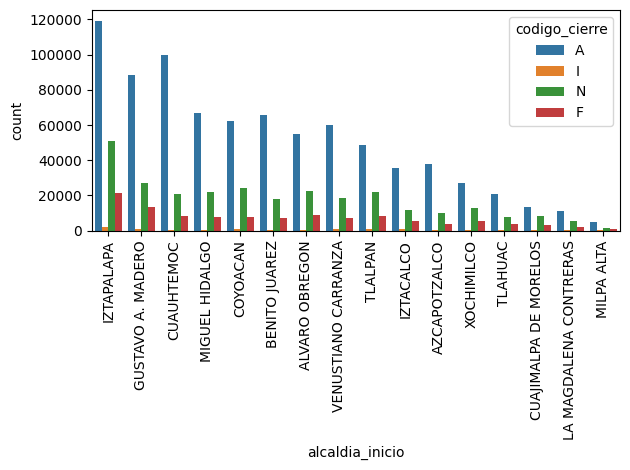

In [6]:
sns.countplot(x='alcaldia_inicio', data=data_original, hue='codigo_cierre', order=data_original['alcaldia_inicio'].value_counts().index)
plt.xticks(rotation=90) 
plt.tight_layout() 

## Balance codigo_cierre_binario

In [7]:
from sklearn.model_selection import train_test_split

X = data.drop(columns='codigo_cierre_binario')
y = data['codigo_cierre_binario']

data_train, data_test, y_train, y_test = train_test_split(X, y,
                                                    test_size = 0.3, 
                                                    random_state = 0) # Holdout

# variable for extract index 
tmp_index = data_train[data_train['codigo_cierre'] == 'A']
remove_n = len(data_train) - len(tmp_index)  # 50%
drop_indices = np.random.choice(tmp_index.index, remove_n, replace=False) # use same index in X train and y train
data_train_balanced = data_train.drop(drop_indices)
X_train_balanced = data_train_balanced.drop(columns='codigo_cierre')
y_train_balanced = y_train.drop(drop_indices)
X_test = data_test.drop(columns='codigo_cierre') # Keep X_test original

In [8]:
# Balanced for train
y_train_balanced.value_counts()

1    286964
0    285119
Name: codigo_cierre_binario, dtype: int64

In [9]:
# Original for test purposes
y_test.value_counts()

1    244781
0    122592
Name: codigo_cierre_binario, dtype: int64

## Normalize numerical features

In [10]:
from sklearn.preprocessing import MinMaxScaler

# Scaler
scaler = MinMaxScaler()

# Train the MinMaxScaler only on train set to avoid data leakage 👌
X_train_balanced_scaled = scaler.fit_transform(X_train_balanced.drop(columns=['fecha_creacion','alcaldia_cierre']))
X_test_scaled = scaler.transform(X_test.drop(columns=['fecha_creacion','alcaldia_cierre']))


In [11]:
# Sample
X_train_balanced_scaled[0]

array([0.66380398, 0.55134901, 0.00182631, 0.        , 0.07156624,
       0.24223167, 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 1.        , 0.        , 0.        ,
       0.        , 0.        , 1.        , 0.        , 0.        ,
       1.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 1.        , 0.        , 0.        , 0.        ,
       0.        , 1.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        ])

## Basic Log Regression

In [12]:
from sklearn.linear_model import LogisticRegression

# Instantiate the model and fit
model = LogisticRegression(solver='newton-cholesky').fit(X_train_balanced_scaled, y_train_balanced)

# Mean accuracy
accuracy = model.score(X_test_scaled, y_test)
print('Accuracy:', accuracy)

Accuracy: 0.5932363020690143


In [13]:
from sklearn.metrics import recall_score

# predictions
y_pred = model.predict(X_test_scaled)

# recall score
recall_score(y_test, y_pred)

0.5216417940934959

## Feature Permutation

In [14]:
from sklearn.inspection import permutation_importance

# Fit model
model = LogisticRegression(solver='newton-cholesky').fit(X_train_balanced_scaled, y_train_balanced)

# Run permutation
permutation_score = permutation_importance(model, X_train_balanced_scaled, y_train_balanced, n_repeats=10)

# Unstack results showing the decrease in performance after shuffling features
importance_df = pd.DataFrame(np.vstack((X_train_balanced.drop(columns=['fecha_creacion','alcaldia_cierre']).columns,
                                        permutation_score.importances_mean)).T)
importance_df.columns=['feature','score decrease']

# Show the important features
importance_df.sort_values(by="score decrease", ascending=False)

,feature,score decrease
36,tipo_incidente_c4_Accidente,0.024816
41,incidente_c4_Choque sin lesionados,0.021024
17,tipo_entrada_LLAMADA DEL 911,0.017869
18,tipo_entrada_RADIO,0.00721
15,tipo_entrada_BOTÓN DE AUXILIO,0.004392
4,sin_enc_hora_creacion,0.004074
25,alcaldia_inicio_CUAUHTEMOC,0.003402
47,incidente_c4_Volcadura,0.002612
39,incidente_c4_Atropellado,0.002465
24,alcaldia_inicio_CUAJIMALPA DE MORELOS,0.002084


In [15]:
# import ydata_profiling

# data.profile_report()

In [28]:
data_original['incidente_c4'].value_counts()

Choque sin lesionados               712721
Choque con lesionados               257772
Atropellado                         141231
Motociclista                         64306
Volcadura                            20257
Ciclista                              7378
Persona atrapada / desbarrancada      6745
Accidente automovilístico             6050
Vehículo atrapadovarado               2467
Otros                                 2328
Choque con prensados                  1209
Vehiculo atrapado                      832
Incidente de tránsito                  649
Vehiculo desbarrancado                 446
Monopatín                               98
Ferroviario                             59
Persona atropellada                     27
Name: incidente_c4, dtype: int64